import requests
import pandas as pd

In [ ]:
summoner_name = "정신력남자"
server = "kr"
region = "asia"
queue = 420
count = 100

In [ ]:
with open("../api_key.txt", "r") as file:
    API_KEY = file.read()

In [ ]:
GET_SUMMONER_BY_NAME = "https://{}.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
GET_MATCH_IDS_BY_PUUID_1 = "https://{}.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?"
GET_MATCH_IDS_BY_PUUID_2 = "start={}&count={}&api_key={}"
GET_MATCH_DATA_BY_MATCH_ID = "https://{}.api.riotgames.com/lol/match/v5/matches/{}?api_key={}"

In [ ]:
def get_puuid_by_summoner_name(server: str, summoner_name: str, api_key: str = API_KEY) -> str:
    summoner_info_response = requests.get(GET_SUMMONER_BY_NAME.format(server, summoner_name, api_key))
    return summoner_info_response.json()["puuid"]

In [ ]:
def build_get_match_ids_by_puuid_request(region: str, puuid: str, api_key: str = API_KEY, startTime: int = None, endTime: int = None, queue: int = None, start: int = 0, count: int = 20):
    request_string = GET_MATCH_IDS_BY_PUUID_1.format(region, puuid)
    for param_name, param_value in {"startTime": startTime, "endTime": endTime, "queue": queue}.items():
        if param_value is None:
            continue
        request_string += f'{param_name}={param_value}&'

    request_string += GET_MATCH_IDS_BY_PUUID_2.format(start, count, api_key)
    return request_string

In [ ]:
def get_match_ids_by_puuid(region: str, puuid: str, api_key: str = API_KEY, startTime: int = None, endTime: int = None, queue: int = None, start: int = 0, count: int = 20):
    request_string = build_get_match_ids_by_puuid_request(
        region=region,
        puuid=puuid,
        api_key=api_key,
        startTime=startTime,
        endTime=endTime,
        queue=queue,
        start=start,
        count=count
    )
    
    match_ids_response = requests.get(request_string)
    return match_ids_response.json()

In [ ]:
import time

def get_match_data_by_match_id(region: str, match_id: str, api_key: str = API_KEY):
    match_data_response = requests.get(GET_MATCH_DATA_BY_MATCH_ID.format(region, match_id, api_key))

    match match_data_response.status_code:
        case 200:
            pass
        case 429:
            print("Waiting because of 429")
            time.sleep(20)
            return get_match_data_by_match_id(region, match_id, api_key)
        case _:
            return match_data_response.status_code

    return match_data_response.json()

In [ ]:
def get_participant_index(puuid: str, match_data: dict) -> int:
    participants = match_data["metadata"]["participants"]
    return participants.index(puuid)

In [ ]:
def get_lane_opponent_match_data(match_data: dict, player_team_position: str, player_puuid: str):
    for player_data in match_data["info"]["participants"]:

        if player_data["teamPosition"] == player_team_position and (player_data["puuid"] != player_puuid):
            return player_data

In [ ]:
puuid = get_puuid_by_summoner_name(server=server, summoner_name=summoner_name)
puuid

In [ ]:
match_ids = get_match_ids_by_puuid(region=region, puuid=puuid, queue=queue, count=count)
match_ids

In [ ]:
from datetime import datetime

def convert_epoch_to_date(epoch_timestamp):
    """
    Convert epoch timestamp in milliseconds to a human-readable date.
    
    Args:
        epoch_timestamp (int): Epoch timestamp in milliseconds.
    
    Returns:
        str: Human-readable date string.
    """
    try:
        # Convert milliseconds to seconds and then to datetime object
        date_time = datetime.fromtimestamp(epoch_timestamp // 1000)
        # Format the datetime object as a string
        formatted_date = date_time.strftime('%Y-%m-%d %H:%M:%S')
        return formatted_date
    except Exception as e:
        print("Error:", e)
        return None

In [293]:
player_stats = []

for i, match_id in enumerate(match_ids):
    match_data = get_match_data_by_match_id(region=region, match_id=match_id)
    participant_index = get_participant_index(puuid=puuid, match_data=match_data)
    player_data = match_data["info"]["participants"][participant_index]

    champion_played = player_data["championName"]
    win = player_data["win"]
    player_team_position = player_data["teamPosition"]
    game_duration = match_data["info"]["gameDuration"]

    lane_opponent_match_data = get_lane_opponent_match_data(match_data=match_data, player_team_position=player_team_position, player_puuid=puuid)
    lane_opponent = lane_opponent_match_data["championName"]

    player_stats.append({"championName": champion_played, "win": win, "laneOpponent": lane_opponent, "gameDuration": game_duration})
    print(player_stats[i])

    print(f'{int(round((i + 1) / len(match_ids) * 100, 0))} % Done.')

[{'championName': 'Gangplank', 'win': True, 'laneOpponent': 'Yone', 'gameDuration': 930}]
1 % Done.
[{'championName': 'Gangplank', 'win': True, 'laneOpponent': 'Yone', 'gameDuration': 930}, {'championName': 'Orianna', 'win': True, 'laneOpponent': 'Leblanc', 'gameDuration': 1529}]
2 % Done.
[{'championName': 'Gangplank', 'win': True, 'laneOpponent': 'Yone', 'gameDuration': 930}, {'championName': 'Orianna', 'win': True, 'laneOpponent': 'Leblanc', 'gameDuration': 1529}, {'championName': 'Alistar', 'win': False, 'laneOpponent': 'Janna', 'gameDuration': 1854}]
3 % Done.
[{'championName': 'Gangplank', 'win': True, 'laneOpponent': 'Yone', 'gameDuration': 930}, {'championName': 'Orianna', 'win': True, 'laneOpponent': 'Leblanc', 'gameDuration': 1529}, {'championName': 'Alistar', 'win': False, 'laneOpponent': 'Janna', 'gameDuration': 1854}, {'championName': 'Alistar', 'win': True, 'laneOpponent': 'Blitzcrank', 'gameDuration': 1189}]
4 % Done.


KeyboardInterrupt: 

In [290]:
df = pd.DataFrame(player_stats, columns=["championName", "win", "laneOpponent", "gameDuration"])
df.head()

,championName,win,laneOpponent,gameDuration
0,Ahri,True,Top,25
1,Ahri,False,Mid,30


In [ ]:
champion_counts = df.groupby("championName").size()
print(champion_counts)
winrates = round(df.groupby("championName")["win"].mean() * 100, 0)
print(winrates)

# Filter rows where championName is 'Orianna'
filtered_df = df[df["championName"] == 'Orianna']

# Group by "laneOpponent" and calculate count and win rate
result_df = filtered_df.groupby("laneOpponent").agg(
    count=pd.NamedAgg(column='win', aggfunc='size'),
    winrate=pd.NamedAgg(column='win', aggfunc='mean')
).reset_index()

# Rename columns for better readability
result_df.rename(columns={'laneOpponent': 'LaneOpponent', 'count': 'Games', 'winrate': 'WinRate'}, inplace=True)

# print(result_df)

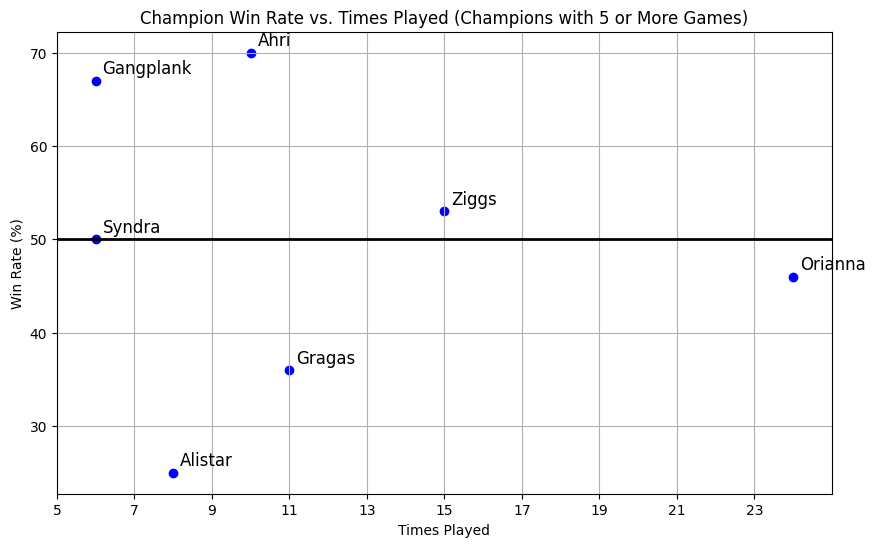

In [284]:
import matplotlib.pyplot as plt

# Filter champions with more than 4 games
filtered_champion_counts = champion_counts[champion_counts >= 5]
filtered_winrates = winrates[champion_counts >= 5]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_champion_counts, filtered_winrates, color='b', marker='o')

# Add labels for each champion
for champion, count, winrate in zip(filtered_champion_counts.index, filtered_champion_counts, filtered_winrates):
    plt.annotate(champion, xy=(count, winrate), xytext=(5, 5), textcoords='offset points', fontsize=12)

# Set labels and title
plt.xlabel('Times Played')
plt.ylabel('Win Rate (%)')
plt.title('Champion Win Rate vs. Times Played (Champions with 5 or More Games)')
plt.grid(True)

# Set x-axis ticks and limits
plt.xticks(range(5, max(filtered_champion_counts) + 1, 2))  # Start at 5, increment by 3
plt.xlim(5, max(filtered_champion_counts) + 1)  # Set x-axis limits

# Draw a horizontal line at y=50% (win rate) and make the grid line thicker
plt.axhline(y=50, color='black', linestyle='-', linewidth=2, label='50% Win Rate')

plt.show()


In [ ]:
# Calculate total count of champions played
total_champions = champion_counts.sum()

# Filter champions with greater than 2% contribution
filtered_champions = champion_counts[champion_counts / total_champions > 0.02]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(filtered_champions, labels=filtered_champions.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Champions Played (Excluding Playrate <= 2%)')
plt.show()

In [ ]:
# Bar Chart with y-axis step size 1
plt.figure(figsize=(10, 6))
plt.bar(result_df["LaneOpponent"], result_df["Games"], label='Games Played')
plt.bar(result_df["LaneOpponent"], result_df["WinRate"], alpha=0.7, label='Winrate')
plt.xlabel('Lane Opponent')
plt.ylabel('Games Played')
plt.title('Orianna Matchups')
plt.legend()
plt.xticks(rotation=45)
plt.yticks(range(0, int(result_df["Games"].max()) + 1, 1))  # Set y-tick positions with step size 1
plt.tight_layout()
plt.show()


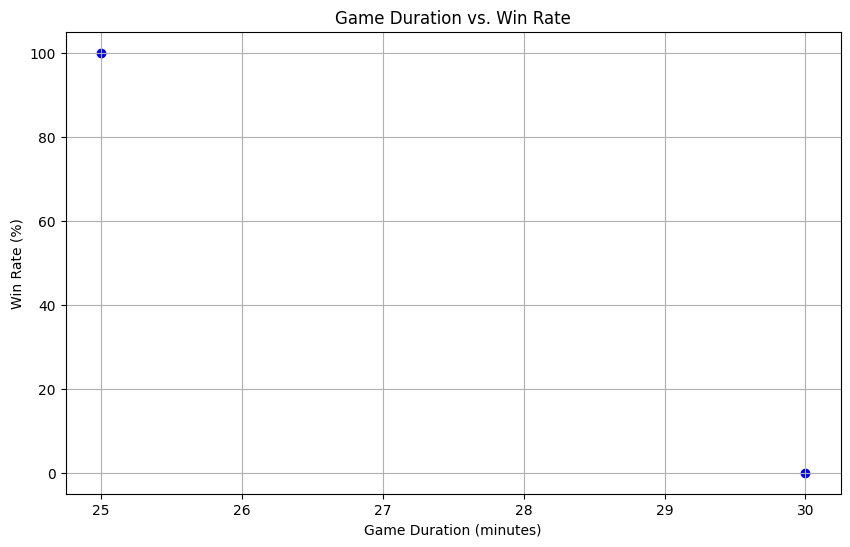

In [286]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace this with your actual data)
player_stats = [
    {"championName": "Ahri", "win": True, "laneOpponent": "Top", "gameDuration": 25},
    {"championName": "Ahri", "win": False, "laneOpponent": "Mid", "gameDuration": 30},
    # ... more data ...
]

df = pd.DataFrame(player_stats, columns=["championName", "win", "laneOpponent", "gameDuration"])

# Calculate win rate (as a percentage)
df["win_rate"] = df["win"].astype(int) * 100

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df["gameDuration"], df["win_rate"], color='b', marker='o')

# Set labels and title
plt.xlabel('Game Duration (minutes)')
plt.ylabel('Win Rate (%)')
plt.title('Game Duration vs. Win Rate')

plt.grid(True)
plt.show()


In [ ]:
# Group data by game duration intervals and calculate average win rate
duration_intervals = pd.cut(df["gameDuration"], bins=range(0, df["gameDuration"].max() + 1, 5))
average_win_rate = df.groupby(duration_intervals)["win_rate"].mean()

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(average_win_rate.index.mid, average_win_rate.values, color='b', marker='o')

# Set labels and title
plt.xlabel('Game Duration (minutes)')
plt.ylabel('Average Win Rate (%)')
plt.title('Average Win Rate vs. Game Duration (5-minute Intervals)')

plt.grid(True)
plt.show()
